# Potential

An electron beam interacts with a specimen through the Coulomb potential of its electrons and nuclei. Thus the total electrostatic potential of the sample is required for quantitative image simulations. Typically, the so-called indepedent atom model (IAM) is used, which neglects any bonding effects and treats the sample as an array of atomic potentials.

## Atomic potential parametrization

The electron charge distribution of an atom can be calculated from a first-principles electronic structure calculation, while the atomic nuclei are point charges at any realistic spatial resolution. Given a charge distribution, the potential can be obtained via Poisson's equation. 

Simulation codes include a parametrization of the atomic potentials, with a table of parameters for each element fitted to Hartree-Fock calculations. Below we show the radial depedence of the electrostatic potential of five selected elements, using the default setting in abTEM. This parametrization by Lobato *et. al.* is one of the latest and most accurate  ([doi:10.1107/S205327331401643X](doi:10.1107/S205327331401643X)).

The radial dependence of the atomic potential for isolated single atoms is shown below.

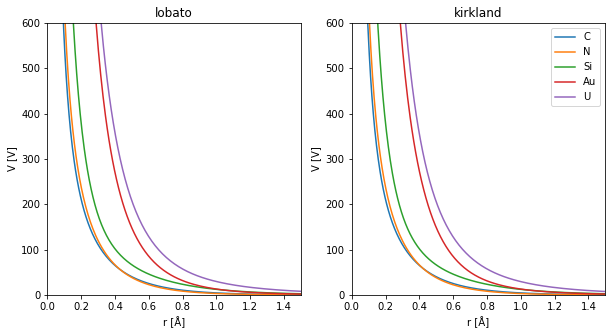

In [1]:
from abtem.potentials.atom import AtomicPotential
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

for parametrization, ax in zip(('lobato', 'kirkland'), (ax1, ax2)):
    for symbol in ['C', 'N', 'Si', 'Au', 'U']:    
        AtomicPotential(symbol, parametrization).show(ax=ax)

    ax.set_title(parametrization)
    ax.set_ylim([0, 600])
    ax.set_xlim([0, 1.5])

plt.legend();

## Independent atom model

The full specimen potential, $V(r)$, is usually obtained as a linear superposition of atomic potentials

$$
    V(r) = \sum_i V_i(r-r_i) \quad,
$$

where $V_i(r)$ is the atomic potential of the $i$'th atom. This is known as the Indenpendent Atom Model (IAM).

Below we create a `Potential` object, which represents a sliced IAM potential using a given parametrization. The parameter `sampling` denotes the spacing of the $xy$-sampling of the potential.

In [2]:
from ase.io import read
from abtem.potentials import Potential

atoms = read('data/srtio3_110.cif')

potential = Potential(atoms, sampling=.05, parametrization='lobato')

In [13]:
potential = Potential(atoms, sampling=.05, chunks=10)


potential.build().array

dask.array<concatenate, shape=(54, 221, 235), dtype=float32, chunksize=(9, 221, 235), chunktype=numpy.ndarray>

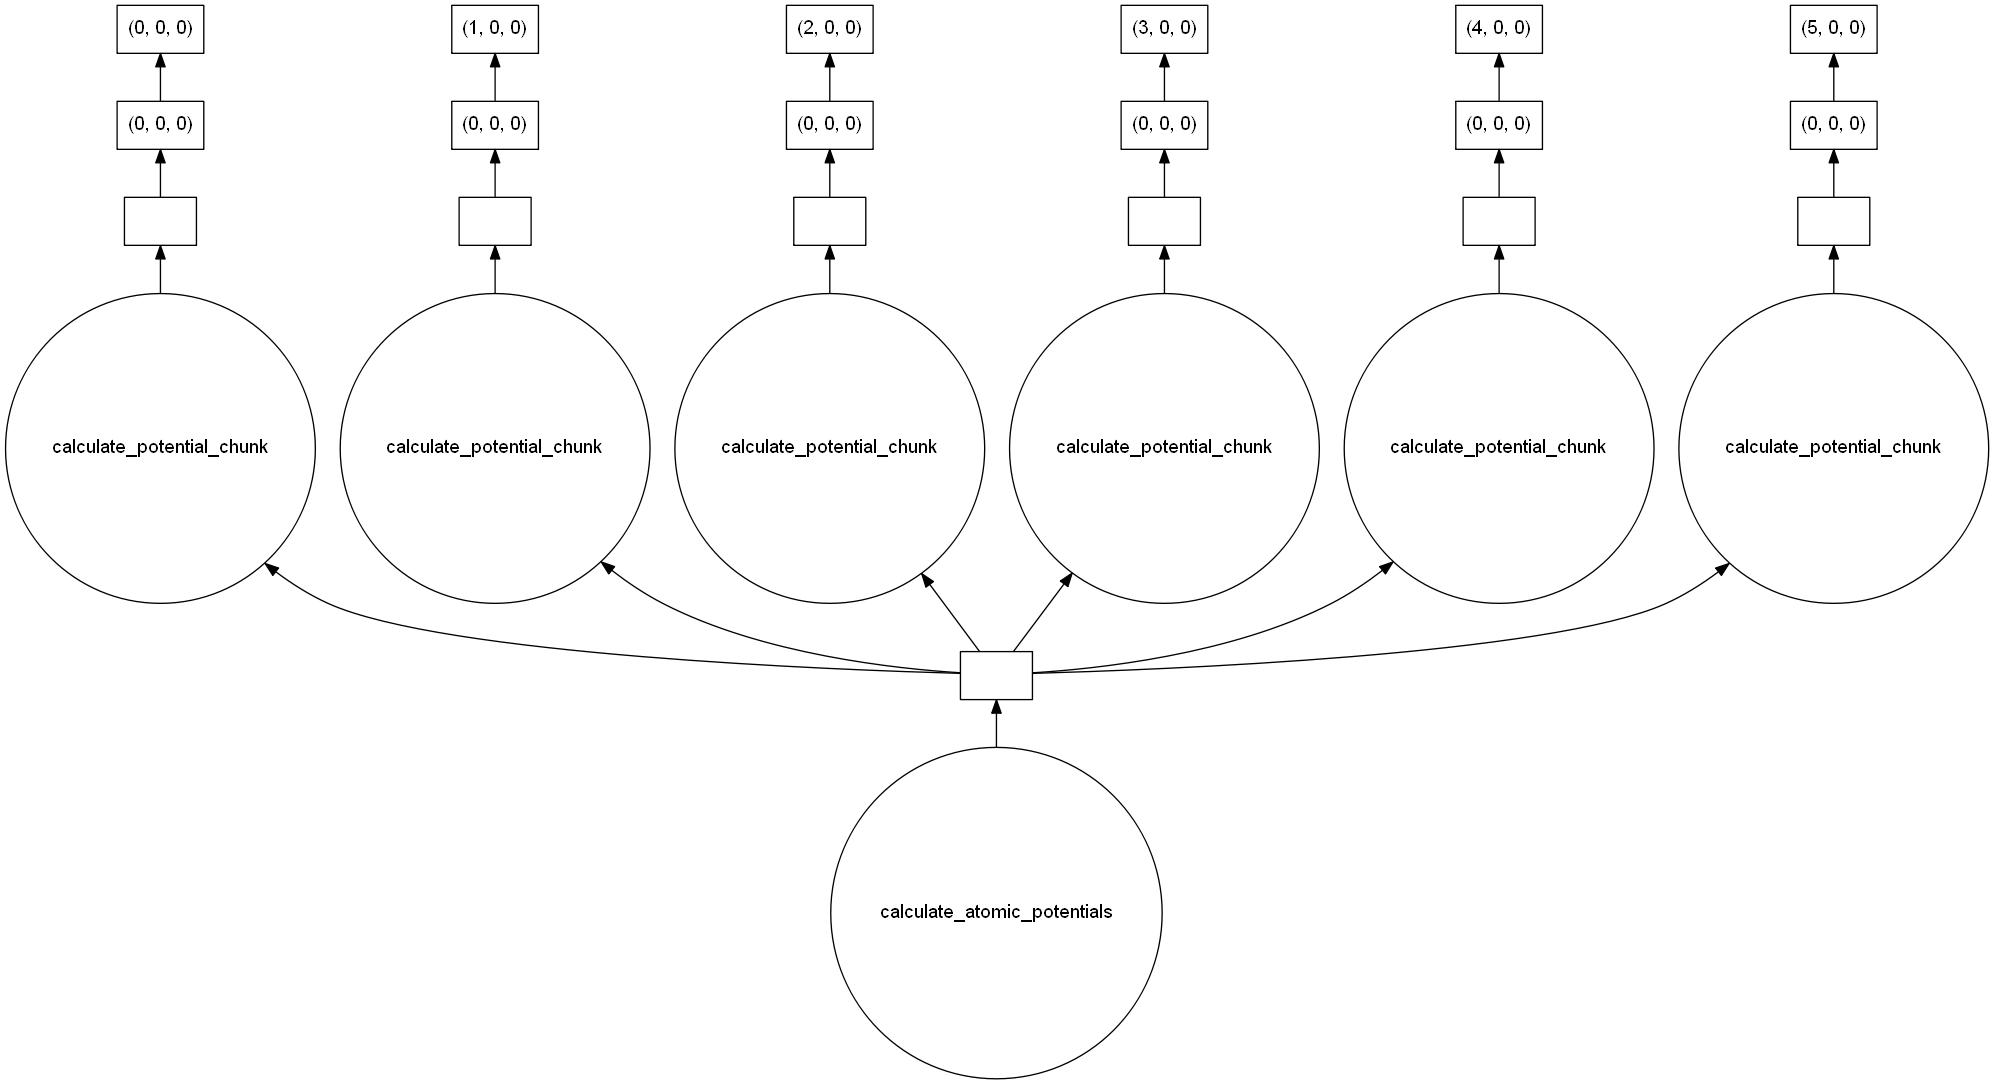

In [15]:
potential.build().array.visualize()

We can show the projected potential (this requires building the potential).

Indexing a `Potential` returns the individual slices. Below we show three slices from the SrTiO<sub>3</sub> potential.

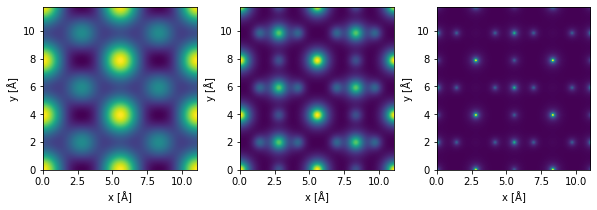

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
potential[1].project().show(ax=ax1)
potential[7].project().show(ax=ax2)
potential[7:12].project().show(ax=ax3);

## Building and saving the potential

The `Potential` object does not store the calculated potential slices. Hence, if a simulation, such as STEM, requires multiple propagations, each slice have to be calculated multiple times. For this reason, abTEM typically precalculates the potential whenever it has to be used more than once. The potential can also be precalculated manually using the `.build` method.

In [4]:
potential_array = potential.build()

This returns an `ArrayPotential` object, which stores each 2D potential slice in a 3D array. The first dimension is the slice index and the last two are the spatial dimensions.

In [5]:
potential_array.array

dask.array<concatenate, shape=(54, 221, 235), dtype=float32, chunksize=(1, 221, 235), chunktype=numpy.ndarray>

The calculated potential can be stored in the `zarr` file format and read back.

In [6]:
potential_array.to_zarr('data/srtio3_110_potential.zarr', overwrite=True)

In [7]:
from abtem.potentials import PotentialArray

PotentialArray.from_zarr('data/srtio3_110_potential.zarr')

## Slicing of the potential

The multislice method requires a mathematical slicing of the potential. The multislice algorithm is only correct in the limit of thin slices, however, more slices increases the computational cost. A reasonable value for slice thickness is generally between $0.5 \ Å$ and $2 \ Å$. The default is $0.5 \ Å$.

### Finite projections

abTEM implements an accurate finite potential projection method. Numerical integration is used to calculate the integrals of the form

$$
V_{proj}^{(i)}(x, y) = \int_{z_i}^{z_i+\Delta z} V(x,y,z) dz \quad ,
$$

where $z_i$ is the $z$-position at the entrance of the $i$'th slice and $\Delta z$ is the slice thickness. The numerical integrals are efficiently handled by the double exponential Tanh–Sinh quadrature, which is designed for accurate results using a minimum number of evaluations for functions with singularities.

#### Cutoff

The potential of a single atom is very localized, but in principle infinite in extent, hence we need to set a reasonable cutoff. The cutoff is calculated by solving the equation

$$
V(r) = V_{tol} \quad ,
$$

where $V_{tol}$ is the error at the cut-off. The equation is solved for each species. The use of the cut-off radius creates a discontinuity; hence, abTEM uses a tapering near the cut-off. $V_{cut}$ can be modified using the `cutoff_tolerance` argument of the `Potential` or `AtomicPotential` objects. abTEM uses a tapering cutoff starting at $85 \ \%$ of the full cutoff.

In [8]:
print('Oxygen cutoff:', AtomicPotential('O', cutoff_tolerance=1e-3).cutoff)
print('Strontium cutoff:', AtomicPotential('Sr', cutoff_tolerance=1e-3).cutoff)

Oxygen cutoff: 2.6349874595919154
Strontium cutoff: 6.346935466282788


### Infinite projections

Since the finite projection method can be computationally demanding, abTEM also implements the infinite projection scheme. The finite integrals are replaced by infinite integrals, which may be evaluated analytically

$$ \int_{-\infty}^{\infty} V(x,y,z) dz \approx \int_{z_i}^{z_i+\Delta z} V(x,y,z) dz $$

The infinite projection of the atomic potential for each atom is assigned to a single slice. The implementation uses the hybrid real-space/Fourier-space approach by W. van den Broek et. al. (https://doi.org/10.1016/j.ultramic.2015.07.005). Using infinite projections is up to 10 times faster on CPU and up to 100 times faster on GPU, especially for potentials with a large numbers of atoms.

Below we create a potential with infinite projections:

In [9]:
potential = Potential(atoms, projection='infinite', sampling=.05)

potential.build()